In [ ]:
!pip3 install ultralytics
!pip3 install wordcloud
!pip3 install pytesseract
!pip3 install imutils
!pip3 install pillow
!pip3 install keras-ocr

In [2]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import cv2
import tensorflow as tf
import os
import keras_ocr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import networkx as nx
from itertools import combinations

model = YOLO("yolov8m.pt")

image_folder = Path("./hateful_memes/img/")
image_paths = list(image_folder.glob("*.png"))

/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/swayam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Demonstration of YOLOv8 inference on a randomly chosen image from the given dataset.


0: 640x480 1 person, 1 tie, 281.6ms
Speed: 2.0ms preprocess, 281.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


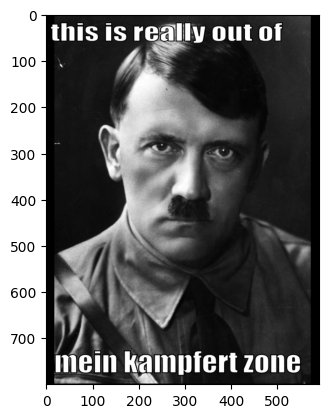

In [3]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(image_paths))

img_1 = Image.open(image_paths[idx])

plt.imshow(img_1)
results = model(img_1)

result = results[0]

Object person detected with probability 0.97
Box coordinates: [19, 59, 572, 791]
Object tie detected with probability 0.29
Box coordinates: [304, 569, 441, 799]


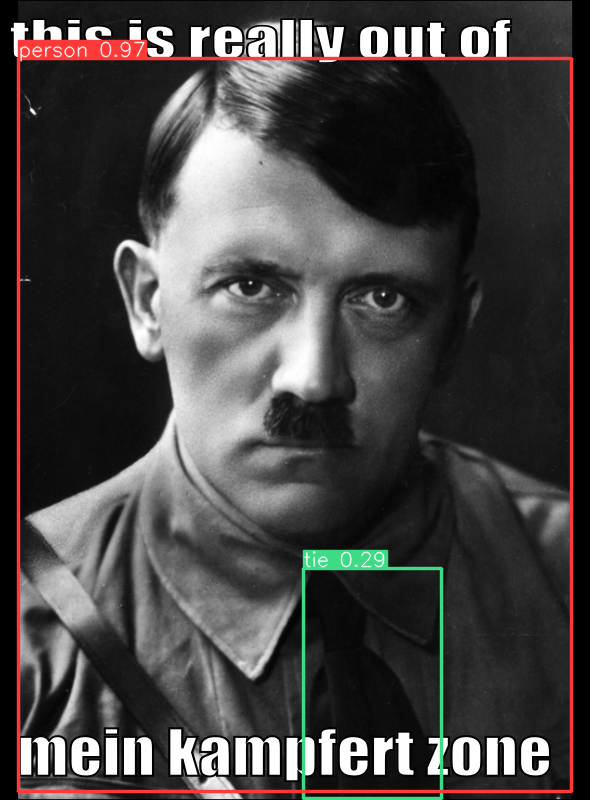

In [4]:
for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])

In [ ]:
# filtered random 500 images
image_paths_filtered = random.sample(image_paths, 500)

all_objects = []
all_probabilities = []
co_occurrences = []

for image_path in tqdm(image_paths_filtered):
    img = Image.open(image_path)
    results = model(img)
    result = results[0]
    
    objects_in_image = [result.names[box.cls[0].item()] for box in result.boxes]
    probabilities_in_image = [box.conf[0].item() for box in result.boxes]

    co_occurrences.extend(combinations(objects_in_image, 2))
    
    all_objects.extend(objects_in_image)
    all_probabilities.extend(probabilities_in_image)

Summary Statistics:
       Probability
count  1849.000000
mean      0.651189
std       0.238212
min       0.250333
25%       0.417468
50%       0.679300
75%       0.889560
max       0.988203


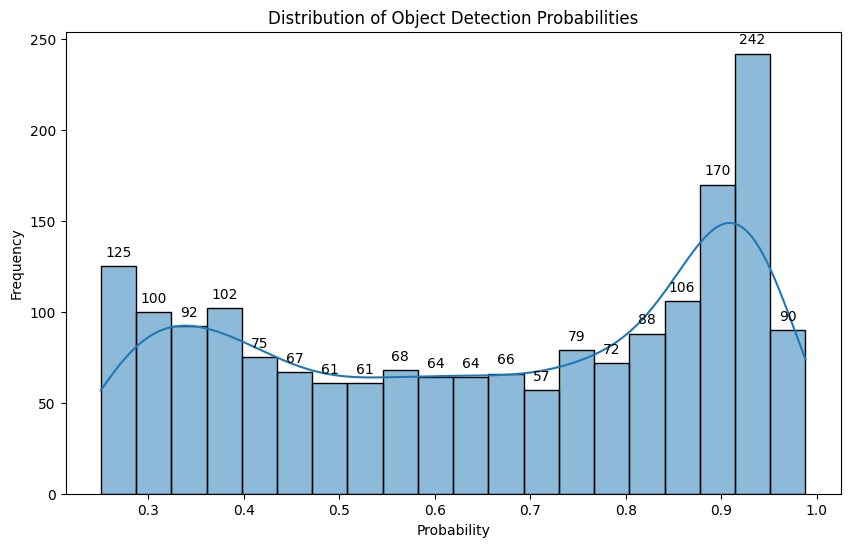

/var/folders/sn/n87ls2012hz6l2qdynmyh12h0000gn/T/ipykernel_672/3478073434.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_objects.values, y=top_objects.index, palette="viridis")


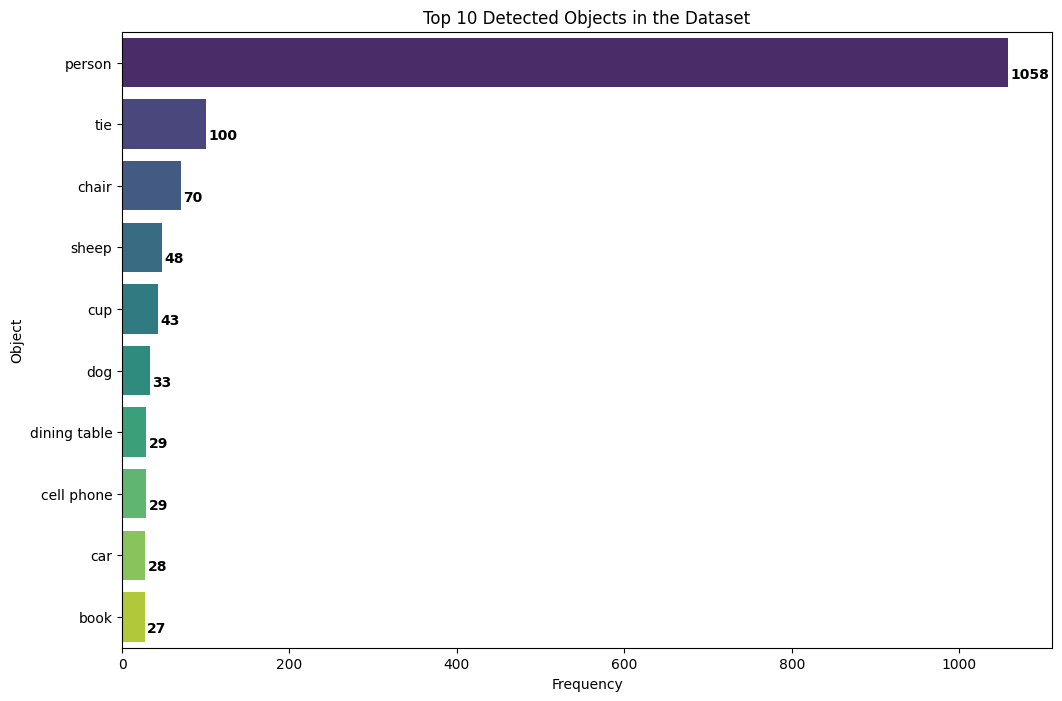

In [6]:
data = pd.DataFrame({'Object': all_objects, 'Probability': all_probabilities})

print("Summary Statistics:")
print(data.describe())

plt.figure(figsize=(10, 6))
sns.histplot(data['Probability'], bins=20, kde=True)
plt.title('Distribution of Object Detection Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

top_n = 10
top_objects = data['Object'].value_counts().head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_objects.values, y=top_objects.index, palette="viridis")
plt.title(f'Top {top_n} Detected Objects in the Dataset')
plt.xlabel('Frequency')
plt.ylabel('Object')

for i, v in enumerate(top_objects.values):
    plt.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    
plt.show()

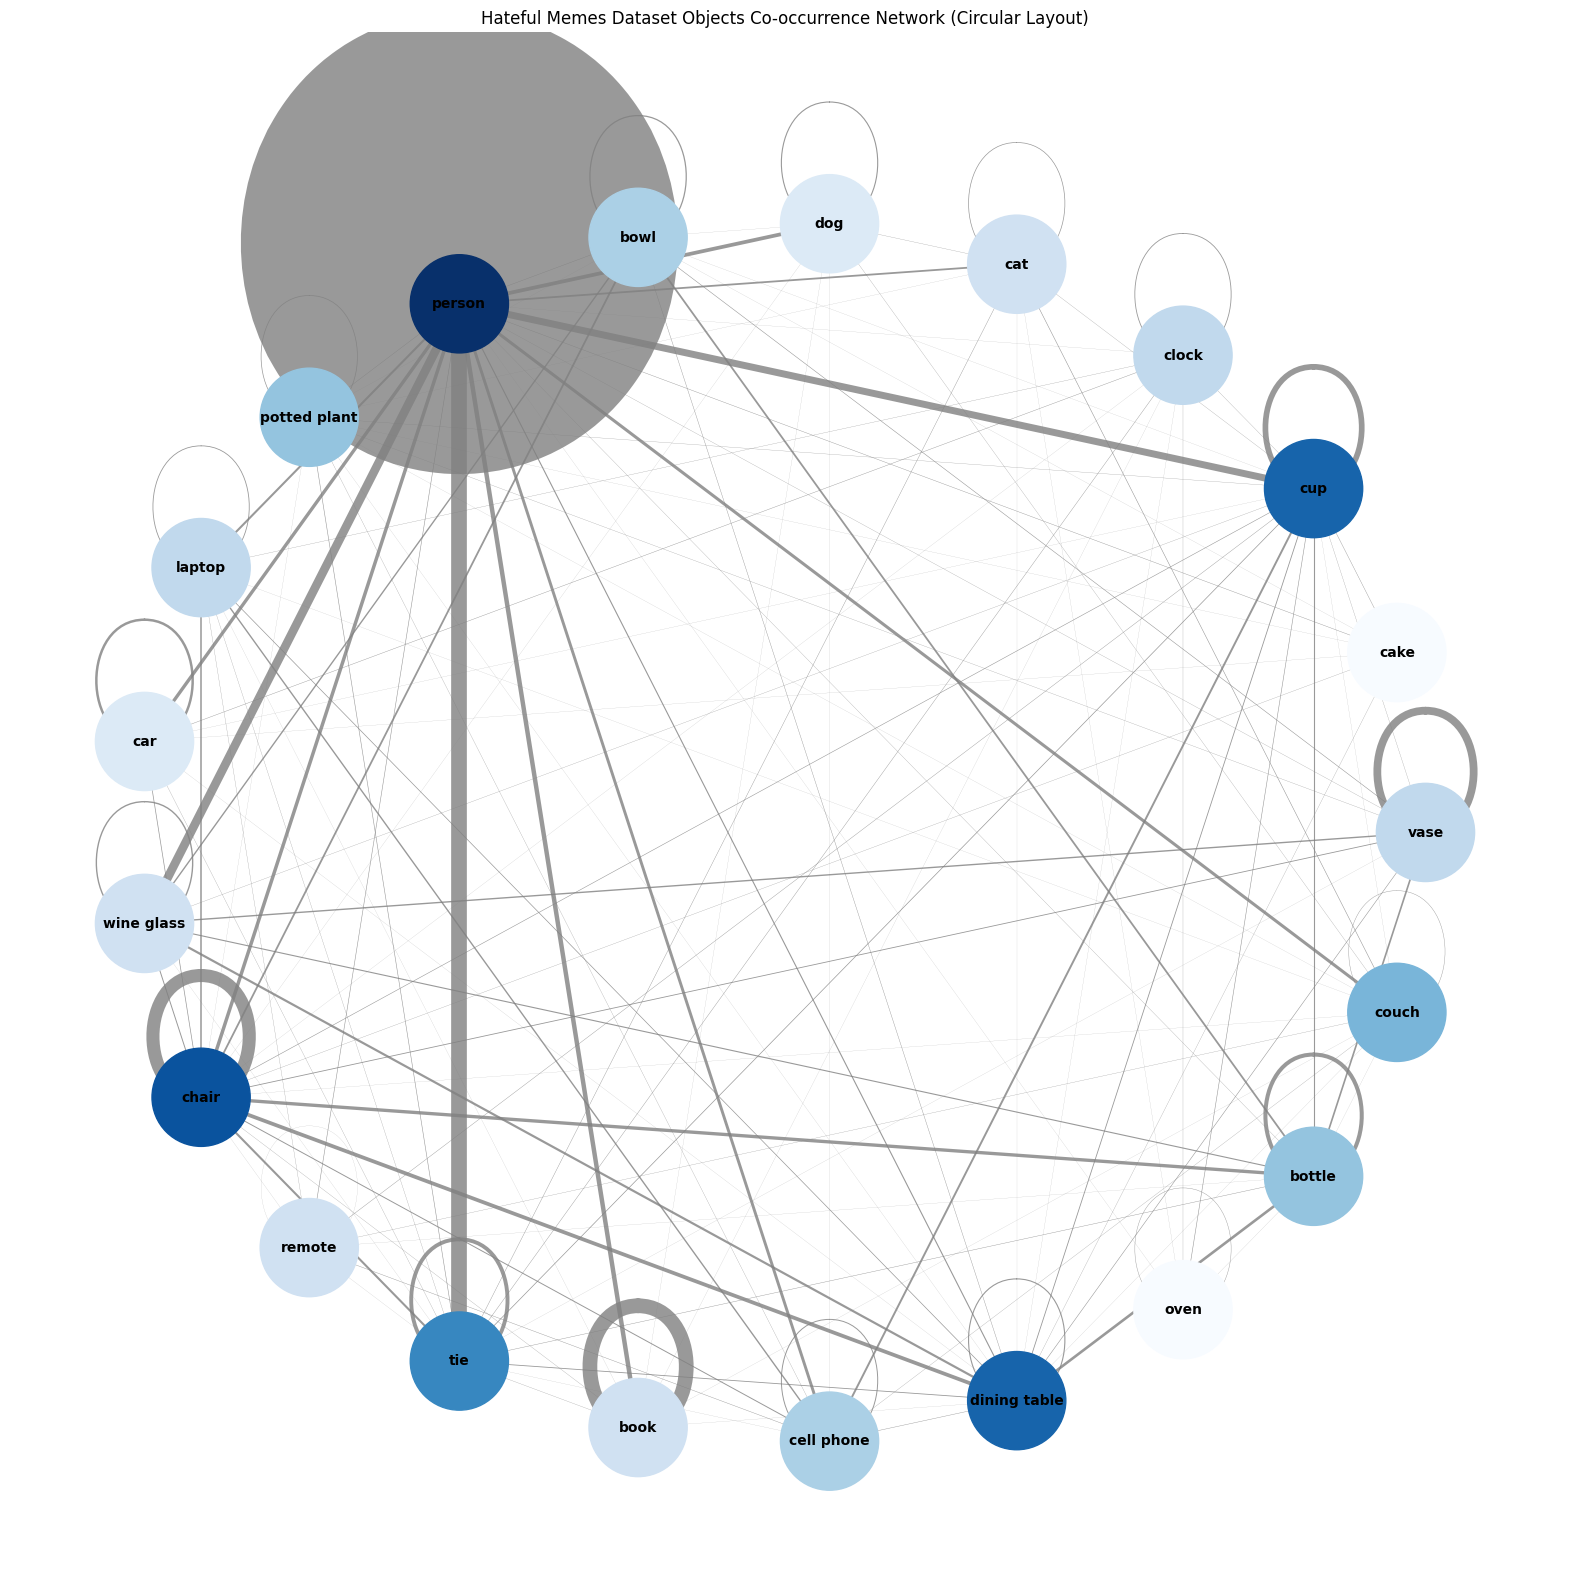

In [7]:
co_occurrence_df = pd.DataFrame(co_occurrences, columns=['Object1', 'Object2'])

co_occurrence_counts = Counter(zip(co_occurrence_df['Object1'], co_occurrence_df['Object2']))

G = nx.Graph()
for (obj1, obj2), weight in co_occurrence_counts.items():
    G.add_edge(obj1, obj2, weight=weight)

min_degree = 10
nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
G = G.subgraph(nodes_to_keep)

pos = nx.circular_layout(G)

node_colors = [G.degree[node] for node in G.nodes]

edge_widths = [0.1 * G[u][v]['weight'] for u, v in G.edges]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Blues, node_size=5000)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')
plt.title('Hateful Memes Dataset Objects Co-occurrence Network (Circular Layout)')
plt.axis('off')
plt.show()

# Task-B

In [46]:
def compute_grad(image_gray, mode:str)->np.ndarray:
    dx = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(dx**2 + dy**2)
    return (mag/mag.max()*255).astype(np.uint8)


def detect_draw(pipeline, image_gray, viz):
    img = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    b = pipeline.recognize([img])
    if viz:
        keras_ocr.tools.drawAnnotations(image=img, predictions=b[0])

    bboxes = []
    for i in range(len(b[0])):
        bboxes.append(b[0][i][1])

    return bboxes

def remove(image_gray, bboxes, offset, dilation_factor):
    mask = np.ones_like(image_gray, dtype=np.uint8) * 255

    blur_factor = 7
    inpaint_radius = 4  

    for bbox in bboxes:
        bb = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]]
        x_min, y_min, x_max, y_max = map(int, bb) # converting to int for ensuring cv2 int type requirement
        cv2.rectangle(mask, (x_min-offset, y_min-offset), (x_max+offset, y_max+offset), (0,0,0), -1)


    # ********************************************************************************************** #
    
    # Option 1: Apply inpainting to the masked regions
        
    mask = cv2.bitwise_not(mask) # inverting the mask to inpaint the masked regions

    # plt.imshow(mask, cmap='gray')
    # plt.show()

    inpainted_image = cv2.inpaint(image_gray.copy(), mask, inpaint_radius, cv2.INPAINT_NS)
    return inpainted_image

    # ********************************************************************************************** #

    # Option 2: Apply Gaussian blur only to the masked regions

    # blurred_masked_image = image_gray.copy()
    # blurred_masked_image[dilated_mask == 0] = cv2.GaussianBlur(image_gray, (blur_factor, blur_factor), 0)[dilated_mask == 0]
    # return blurred_masked_image

    # ********************************************************************************************** #
    
    # Option 3: Apply naive bitwise AND operation for masking

    # kernel = np.ones((dilation_factor, dilation_factor), np.uint8)
    # dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    # masked_image = cv2.bitwise_and(image_gray, dilated_mask)
    # return masked_image

    # ********************************************************************************************** #

In [51]:
def main(pipeline, image_gray, offset):
    mag = compute_grad(image_gray,"single")
    bboxes = detect_draw(pipeline, mag, viz=True)
    masked_image = remove(image_gray, bboxes, offset=10, dilation_factor=10)
    return masked_image

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/swayam/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/swayam/.keras-ocr/crnn_kurapan.h5


1/1 [==============================] - 1s 851ms/step


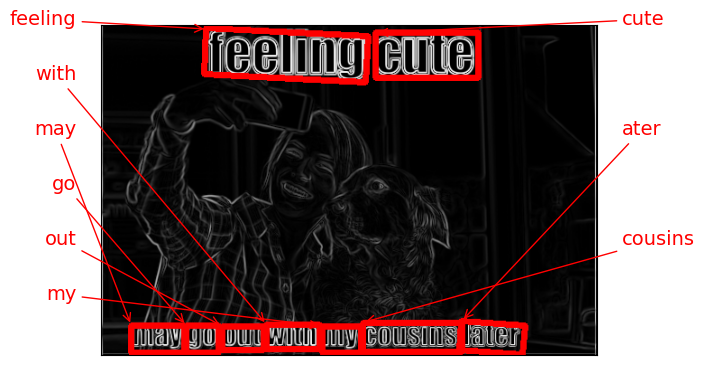

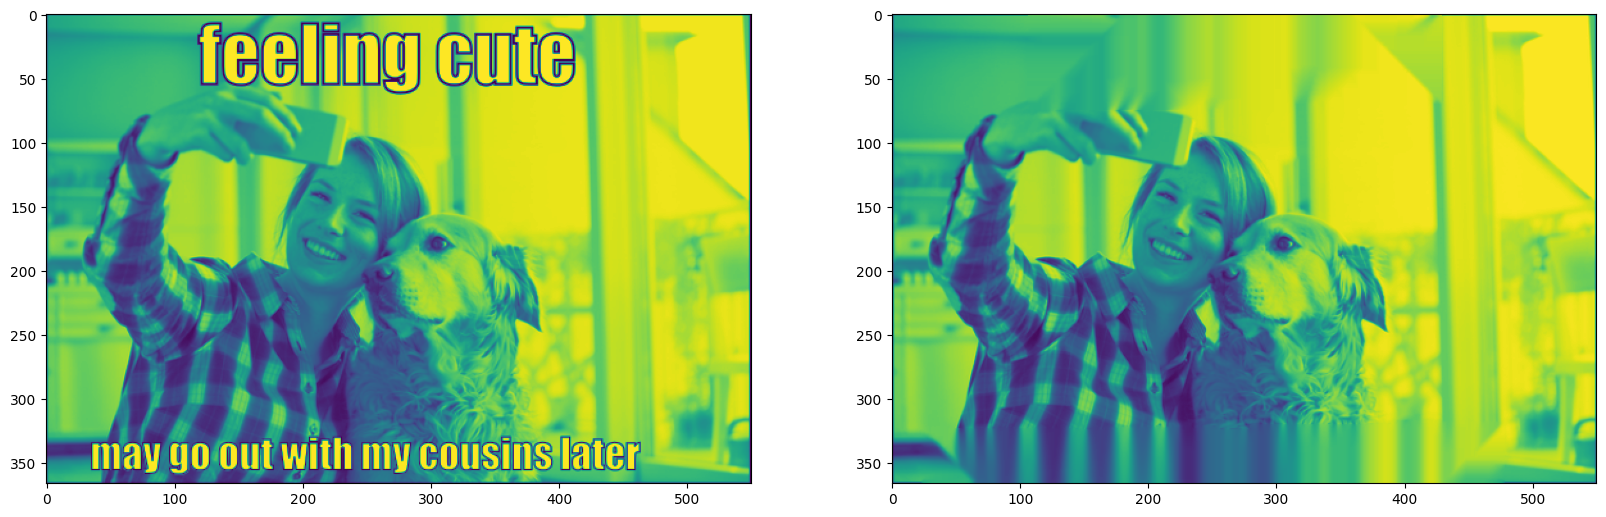

In [87]:
image = cv2.imread(str(image_paths[100]))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = main(pipeline,image_gray,0)
fig, ax = plt.subplots(1,2,figsize=(20,7))

ax[0].imshow(image_gray)
ax[1].imshow(masked_image)


0: 448x640 1 person, 1 dog, 246.0ms
Speed: 3.4ms preprocess, 246.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Object dog detected with probability 0.93
Box coordinates: [232, 154, 390, 364]
Object person detected with probability 0.92
Box coordinates: [28, 52, 301, 363]


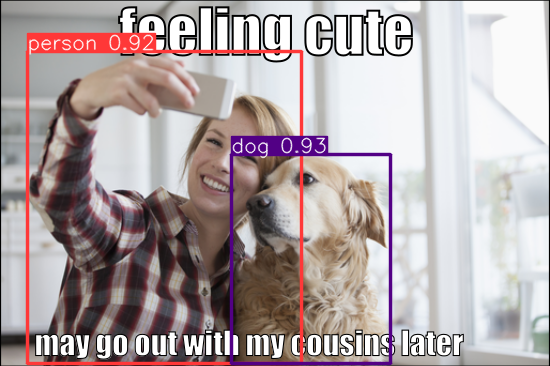

In [88]:
results = model(image)
result = results[0]

for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])


0: 448x640 1 person, 1 dog, 1 remote, 1 cell phone, 258.0ms
Speed: 2.2ms preprocess, 258.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Object person detected with probability 0.75
Box coordinates: [28, 62, 299, 360]
Object dog detected with probability 0.59
Box coordinates: [233, 154, 386, 321]
Object remote detected with probability 0.46
Box coordinates: [146, 76, 236, 121]
Object cell phone detected with probability 0.34
Box coordinates: [147, 76, 236, 121]


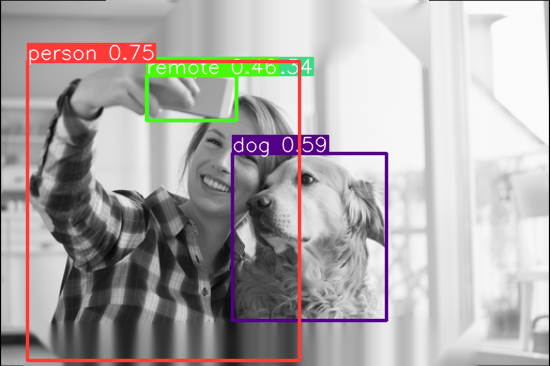

In [89]:
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
masked_image_rgb = np.array(masked_image_rgb)
masked_image_rgb = np.expand_dims(masked_image_rgb, axis=0)

masked_image_rgb = masked_image_rgb.reshape(image.shape)

results = model(masked_image_rgb)
result = results[0]

for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])